In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.metrics
from tensorflow._api.v2.data import AUTOTUNE

In [3]:
(train_dataset, validation_dataset, test_dataset), info_ds = tfds.load("colorectal_histology",
                                                   split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                   shuffle_files=True,
                                                   as_supervised=True,
                                                   with_info= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incompleteNCP3HN/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [4]:
print(info_ds)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='~/tensorflow_datasets/colorectal_histology/2.0.0',
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis,

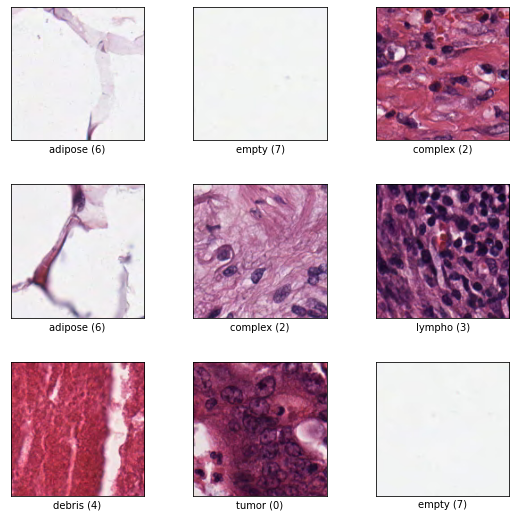

In [5]:
fig = tfds.show_examples(train_dataset, info_ds)

In [6]:
print(info_ds.features["label"].names)

['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


In [7]:
class_names = info_ds.features["label"].names

In [8]:
def normalize_image(image, label):
  return tf.cast(image, tf.float32)/255.0, label

In [9]:
def configure_train(ds):
  ds = ds.map(normalize_image, num_parallel_calls=AUTOTUNE)
  ds = ds.cache()
  ds = ds.shuffle(info_ds.splits['train'].num_examples)
  ds = ds.batch(32)
  ds = ds.prefetch(AUTOTUNE)
  return ds

In [10]:
def configure_validation(ds):
  ds = ds.map(normalize_image, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(32)
  ds = ds.prefetch(AUTOTUNE)
  return ds

In [11]:
def configure_test(ds):
  ds = ds.map(normalize_image, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(32)
  ds = ds.prefetch(AUTOTUNE)
  return ds

In [12]:
train_dataset = configure_train(train_dataset)
test_dataset = configure_test(test_dataset)
validation_dataset = configure_validation(validation_dataset)

In [13]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(150,
                                  150,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [14]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [15]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.005)

In [16]:
model.compile(
  optimizer=tfa.optimizers.RectifiedAdam(learning_rate=1e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [17]:
checkpoint_filepath = '/content/sample_data/Weights'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=7)

In [19]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(
  train_dataset, validation_data = validation_dataset, callbacks = [model_checkpoint_callback, callback, early],
  epochs=100, verbose=1
)

Epoch 1/100
125/125 [==============================] - 23s 71ms/step - loss: 1.2334 - accuracy: 0.5370 - val_loss: 2.1431 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 2/100
125/125 [==============================] - 8s 62ms/step - loss: 0.7643 - accuracy: 0.7095 - val_loss: 2.4233 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 3/100
125/125 [==============================] - 8s 62ms/step - loss: 0.6919 - accuracy: 0.7315 - val_loss: 3.1887 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 4/100
125/125 [==============================] - 8s 61ms/step - loss: 0.5853 - accuracy: 0.7703 - val_loss: 1.8364 - val_accuracy: 0.4460 - lr: 0.0010
Epoch 5/100
125/125 [==============================] - 8s 62ms/step - loss: 0.5570 - accuracy: 0.7962 - val_loss: 1.1056 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 6/100
125/125 [==============================] - 8s 63ms/step - loss: 0.5585 - accuracy: 0.7883 - val_loss: 0.8509 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 7/100
125/125 [==============================] - 8s

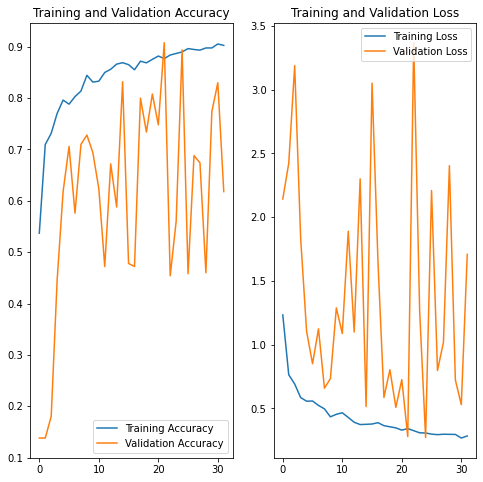

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(history.history['accuracy'])

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model.load_weights(checkpoint_filepath)

In [22]:
model.evaluate(test_dataset)

16/16 [==============================] - 1s 31ms/step - loss: 0.3051 - accuracy: 0.9100


[0.30508261919021606, 0.9100000262260437]

In [23]:
class_names = info_ds.features["label"].names
print(class_names)

['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


In [24]:
predictions = model.predict(test_dataset)

16/16 [==============================] - 0s 10ms/step


In [25]:
predictions.shape

(500, 8)

In [26]:
print(predictions[0])

[2.5090009e-03 8.4830427e-01 3.0556899e-03 2.1143630e-03 1.4037244e-01
 1.6826132e-03 1.8196823e-03 1.4183082e-04]


In [27]:
preds = []
for i in range(500):
  preds.append(np.argmax(predictions[i]))

In [28]:
numpy_labels = []
for images, labels in test_dataset.take(-1): 
    numpy_images = images.numpy()
    numpy_labels.append(labels.numpy())
real_labels = list(chain.from_iterable(numpy_labels))

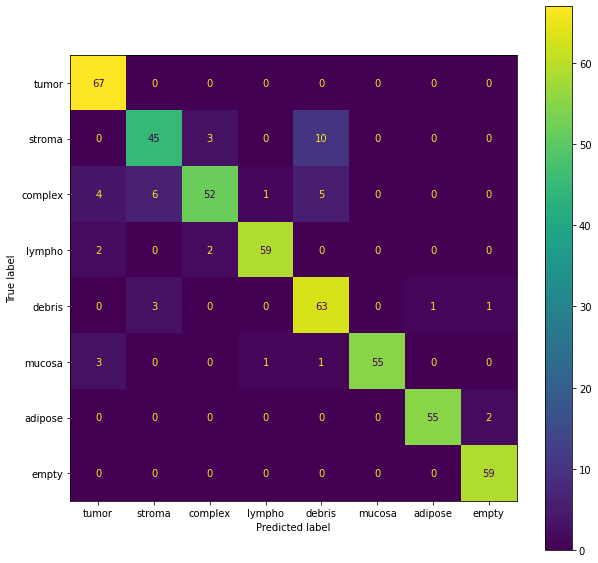

In [29]:
confusion_matrix = sklearn.metrics.confusion_matrix(real_labels, preds)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)

cm_display.plot(ax=ax)
plt.show()

In [34]:
print(sklearn.metrics.classification_report(real_labels, preds))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        67
           1       0.83      0.78      0.80        58
           2       0.91      0.76      0.83        68
           3       0.97      0.94      0.95        63
           4       0.80      0.93      0.86        68
           5       1.00      0.92      0.96        60
           6       0.98      0.96      0.97        57
           7       0.95      1.00      0.98        59

    accuracy                           0.91       500
   macro avg       0.92      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500

